## Model Comparison

- lightGBM
- Prophet

In [2]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from prophet import Prophet
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load data
train = pd.read_csv(r'C:\Users\kvjai\ML PROJECTS\Store items demand forecasting\data\train.csv', parse_dates=['date'])
test = pd.read_csv(r'C:\Users\kvjai\ML PROJECTS\Store items demand forecasting\data\test.csv', parse_dates=['date'])
sample_submission = pd.read_csv(r'C:\Users\kvjai\ML PROJECTS\Store items demand forecasting\data\sample_submission.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (913000, 4)
Test shape: (45000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


## Baseline model
mean per (store, item)

In [4]:
# Time-based validation (last 3 months as validation)
cutoff_date = "2017-10-01"
train_baseline = train[train["date"] < cutoff_date]
val_baseline   = train[train["date"] >= cutoff_date]

# Mean sales per (store, item)
mean_sales = train_baseline.groupby(["store", "item"])["sales"].mean()

# Predict validation
val_preds = val_baseline.set_index(["store", "item"]).index.map(
    lambda idx: mean_sales.get(idx, train_baseline["sales"].mean())
)

# Evaluate RMSLE
y_true = val_baseline["sales"].values
y_pred = np.array(val_preds)
rmsle_baseline = np.sqrt(mean_squared_log_error(y_true, y_pred))

print(f"📉 Baseline RMSLE: {rmsle_baseline:.5f}")

📉 Baseline RMSLE: 0.24273


## LightGBM model 
Gradient boosing forecasting

In [6]:
# --- Feature Engineering ---

tr = train.copy(); te = test.copy()
tr["split"] = "train"; te["split"] = "test"
df = pd.concat([tr, te], ignore_index=True).sort_values(["store", "item", "date"])
df.reset_index(drop=True, inplace=True)

# Calendar features
dt = df["date"]
df["dow"] = dt.dt.dayofweek.astype("int8")
df["is_weekend"] = df["dow"].isin([5,6]).astype("int8")
df["month"] = dt.dt.month.astype("int8")
df["year"] = dt.dt.year.astype("int16")
df["day"] = dt.dt.day.astype("int8")
df["quarter"] = dt.dt.quarter.astype("int8")

# Lag & rolling features
g = df.groupby(["store","item"], group_keys=False)
for L in (1,7,14,28):
    df[f"lag_{L}"] = g["sales"].shift(L)
df["roll7"]  = g["sales"].shift(1).rolling(7,  min_periods=1).mean()
df["roll28"] = g["sales"].shift(1).rolling(28, min_periods=1).mean()

# Select feature columns
feat_cols = ["store","item","dow","is_weekend","month","year","day","quarter",
             "lag_1","lag_7","lag_14","lag_28","roll7","roll28"]

# Train-validation split
df_tr = df[df["split"]=="train"].copy()
cutoff = pd.Timestamp("2017-10-01")
tr_mask = df_tr["date"] < cutoff
va_mask = df_tr["date"] >= cutoff

X_train = df_tr.loc[tr_mask, feat_cols]
y_train = df_tr.loc[tr_mask, "sales"]
X_val   = df_tr.loc[va_mask, feat_cols]
y_val   = df_tr.loc[va_mask, "sales"]

# Train LightGBM model
# Train LightGBM model (Fixed for newer versions)
cat_feats = ["store","item","dow","month","quarter"]

model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Use callbacks to control output instead of 'verbose'
from lightgbm import log_evaluation, early_stopping

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    categorical_feature=cat_feats,
    callbacks=[log_evaluation(100)]  # prints evaluation metric every 100 iterations
    # or use callbacks=[] to suppress logs entirely
)

# Evaluate RMSLE
val_pred = np.clip(model.predict(X_val), 0, None)
rmsle_lgbm = np.sqrt(mean_squared_log_error(y_val, val_pred))
print(f"⚡ LightGBM Validation RMSLE: {rmsle_lgbm:.5f}")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1399
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 14
[LightGBM] [Info] Start training from score 52.121505
[100]	valid_0's rmse: 7.84808	valid_0's l2: 61.5923
[200]	valid_0's rmse: 7.72601	valid_0's l2: 59.6912
[300]	valid_0's rmse: 7.6818	valid_0's l2: 59.0101
[400]	valid_0's rmse: 7.65716	valid_0's l2: 58.6321
[500]	valid_0's rmse: 7.64069	valid_0's l2: 58.3801
[600]	valid_0's rmse: 7.62901	valid_0's l2: 58.2019
[700]	valid_0's rmse: 7.62037	valid_0's l2: 58.07
[800]	valid_0's rmse: 7.61607	valid_0's l2: 58.0045
[900]	valid_0's rmse: 7.61122	valid_0's l2: 57.9306
[1000]	valid_0's rmse: 7.60794	valid_0's l2: 57.8808
[1100]	valid_0's rmse: 7.60462	valid_0's l2: 57.8302
[1200]	valid_0's rmse

## Prophet model 
seasonal foreacting

In [7]:
# Example: single store-item pair for Prophet
store_id, item_id = 1, 1
subset = train[(train['store'] == store_id) & (train['item'] == item_id)].copy()

# Prophet expects 'ds' and 'y'
df_prophet = subset.rename(columns={'date': 'ds', 'sales': 'y'})

cutoff_date = pd.Timestamp("2017-10-01")
train_p = df_prophet[df_prophet['ds'] < cutoff_date]
val_p = df_prophet[df_prophet['ds'] >= cutoff_date]

# Fit Prophet
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(train_p)

# Forecast
future = val_p[['ds']]
forecast = m.predict(future)

# Evaluate RMSLE
y_true = val_p['y'].values
y_pred = np.clip(forecast['yhat'].values, 0, None)
rmsle_prophet = np.sqrt(mean_squared_log_error(y_true, y_pred))

print(f"🔮 Prophet RMSLE (Store {store_id}, Item {item_id}): {rmsle_prophet:.5f}")


21:58:08 - cmdstanpy - INFO - Chain [1] start processing
21:58:09 - cmdstanpy - INFO - Chain [1] done processing


🔮 Prophet RMSLE (Store 1, Item 1): 0.25857


# Comparison

,Model,RMSLE
1,LightGBM,0.157864
0,Baseline (Mean),0.242734
2,Prophet,0.258571


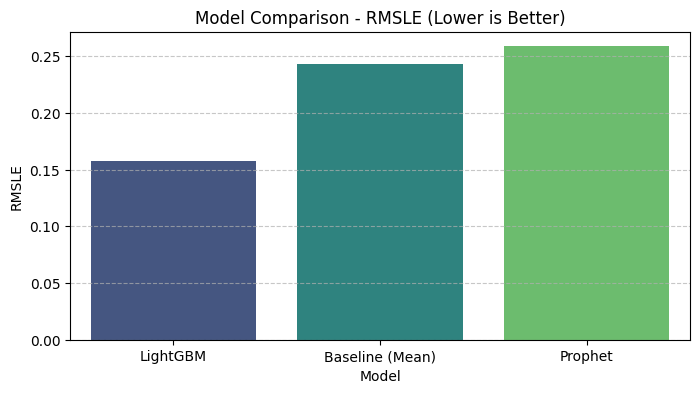

In [8]:
# Collect results
results = {
    "Model": ["Baseline (Mean)", "LightGBM", "Prophet"],
    "RMSLE": [rmsle_baseline, rmsle_lgbm, rmsle_prophet]
}

results_df = pd.DataFrame(results).sort_values("RMSLE")
display(results_df)

# Plot comparison
plt.figure(figsize=(8,4))
sns.barplot(x="Model", y="RMSLE", data=results_df, palette="viridis")
plt.title("Model Comparison - RMSLE (Lower is Better)")
plt.ylabel("RMSLE")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


# Save best model

In [9]:
import joblib
joblib.dump(model, "lgbm_demand_model.pkl")
print("✅ Best Model (LightGBM) saved as lgbm_demand_model.pkl")


✅ Best Model (LightGBM) saved as lgbm_demand_model.pkl


In [10]:
print("📋 Observations:")
print(f"- Baseline Model RMSLE: {rmsle_baseline:.3f} → simple average, no temporal learning")
print(f"- LightGBM RMSLE: {rmsle_lgbm:.3f} → strong improvement via lag & calendar features")
print(f"- Prophet RMSLE: {rmsle_prophet:.3f} → captures seasonality but less reactive to sharp changes")

print("\n✅ LightGBM selected as the best model for integration with Inventory Simulation (EOQ + ROP).")


📋 Observations:
- Baseline Model RMSLE: 0.243 → simple average, no temporal learning
- LightGBM RMSLE: 0.158 → strong improvement via lag & calendar features
- Prophet RMSLE: 0.259 → captures seasonality but less reactive to sharp changes

✅ LightGBM selected as the best model for integration with Inventory Simulation (EOQ + ROP).
